# Modeling halo shape distributions across mass and redshift

This notebook sketches the performance of a model for the probability distribution of halo axis ratios, $P({\rm B/A}\vert M_{\rm halo}, z)$ and $P({\rm C/A}\vert M_{\rm halo}, z).$ In order to locally run the notebook, you'll need to have Halotools installed and also to have downloaded the relevant Bolshoi-Planck and Multidark halo catalogs. 

We start out by grabbing a few samples of halos of different mass and redshift. At each of $z=0,\ z=0.5,$ and $z=1,$ we'll grab a sample of halos of mass $\log M_{\rm halo}/M_{\odot}\approx11.5, 12.5, 13.5,$ and $14.$ The two lower-mass samples will come from Bolshoi-Planck, the two higher-mass samples will come from Multidark. 

In [1]:
from retrieve_halo_sample import retrieve_host_halos
h0_z0, h1_z0, h2_z0, h3_z0 = retrieve_host_halos(0.)
h0_z0p5, h1_z0p5, h2_z0p5, h3_z0p5 = retrieve_host_halos(0.5)
h0_z1, h1_z1, h2_z1, h3_z1 = retrieve_host_halos(1.)

### Analytical form of the model

At a given mass and redshift, we will model $B/T \equiv 1 - 1/(1+x),$ where the stochastic variable $x$ follows a generalized gamma function:

$$
P(x; \alpha, \beta) = \frac{\vert \beta\vert}{\Gamma(\alpha)}e^{-x^{\beta}}x^{\alpha\beta-1}
$$

Let's look the B/A distribution for present-day cluster-mass halos to verify that this functional form broadly captures what is seen in gravity-only N-body simulations. 

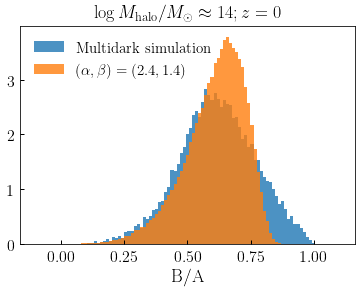

In [2]:
from scipy.stats import gengamma

fig, ax = plt.subplots(1, 1)
rbins = np.linspace(-0.1, 1.1, 100)

__=ax.hist(h3_z0['halo_b_to_a'], bins=rbins, density=True, alpha=0.8, 
            color=mblue, label=r'${\rm Multidark\ simulation}$')

npts = int(1e5)
alpha, beta = 2.4, 1.4
model_b_to_a = 1-1./(1 + gengamma.rvs(alpha, beta, size=npts))
__=ax.hist(model_b_to_a, bins=rbins, density=True, alpha=0.8, 
            color=morange, label=r'$(\alpha, \beta)=(2.4, 1.4)$')

leg = ax.legend()
xlabel = ax.set_xlabel(r'${\rm B/A}$')
title = ax.set_title(r'$\log M_{\rm halo}/M_{\odot}\approx14; z=0$')

The model is not perfect, but it's a reasonably good fit, and we'll see below that we can achieve this level of agreement across a wide range of mass and redshift by simply modeling $\alpha=\alpha(M_{\rm halo}, z)$ and $\beta=\beta(M_{\rm halo}, z).$

We will model the distribution of ${\rm C/A}$ by defining ${\rm C/B}\equiv\delta_{0}-y,$ where $y$ is generalized Gamma distributed, and then by defining ${\rm C/A\equiv(C/B)\cdot(B/A)}.$ Doing things this way will help us respect the boundary condition that $0<{\rm C/A\leq B/A}.$ So we will need to separately calibrate the mass- and redshift-dependence of the distribution of $y$ in our modeling of ${\rm C/A}.$

Finally, we will also look at the derived quantities of ellipticity, $e,$ and prolaticity, $p,$ defined as follows:

$$
r \equiv 1 + {\rm B/A}^2 + {\rm C/A}^2\\
e \equiv \left[1 - ({\rm C/A})^2\right]/\ 2r\\
p \equiv \left[1 - 2\cdot({\rm B/A})^2 + ({\rm C/A})^2\right]/\ 2r
$$

## Modeling $\alpha(M_{\rm halo}, z)$ and $\beta(M_{\rm halo}, z)$

We will capture the relationship between $M_{\rm halo}, z, \alpha, $and $\beta$ via sigmoid functions. This will guarantee our function's behavior is smooth and bounded, and that we can add multi-dimensional complexity simply by chaining together layers of sigmoid functions, just like in a neural network. For dependence upon just $M_{\rm halo}$ and $z,$ we'll find that only a two-link chain gives us sufficient flexibilty for $\mathcal{O}(10\%)$ accuracy on the modeled distributions. 

The two cells below show how $\alpha_{\rm B/A}$ and $\beta{\rm B/A}$ vary with halo mass and redshift. The parameters $\alpha_{\rm C/B}$ and $\beta{\rm C/B}$ have been similarly calibrated, so here we just roughly look at the general trend. 

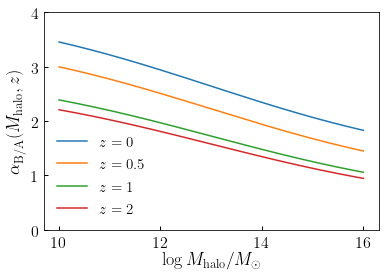

In [3]:
from ellipsoidal_halo_model import _b_to_a_gengamma_alpha

logmarr = np.linspace(10, 16, 1000)

fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(0, 4)
__=ax.plot(logmarr, _b_to_a_gengamma_alpha(logmarr, 0), label=r'$z=0$')
__=ax.plot(logmarr, _b_to_a_gengamma_alpha(logmarr, 0.5), label=r'$z=0.5$')
__=ax.plot(logmarr, _b_to_a_gengamma_alpha(logmarr, 1), label=r'$z=1$')
__=ax.plot(logmarr, _b_to_a_gengamma_alpha(logmarr, 2), label=r'$z=2$')

xlabel = ax.set_xlabel(r'$\log M_{\rm halo}/M_{\odot}$')
ylabel = ax.set_ylabel(r'$\alpha_{\rm B/A}(M_{\rm halo}, z)$')
leg = ax.legend()

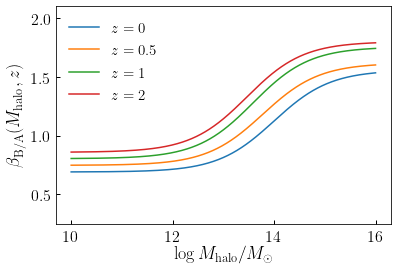

In [4]:
from ellipsoidal_halo_model import _b_to_a_gengamma_beta

logmarr = np.linspace(10, 16, 1000)

fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(0.25, 2.1)
__=ax.plot(logmarr, _b_to_a_gengamma_beta(logmarr, 0), label=r'$z=0$')
__=ax.plot(logmarr, _b_to_a_gengamma_beta(logmarr, 0.5), label=r'$z=0.5$')
__=ax.plot(logmarr, _b_to_a_gengamma_beta(logmarr, 1), label=r'$z=1$')
__=ax.plot(logmarr, _b_to_a_gengamma_beta(logmarr, 2), label=r'$z=2$')

xlabel = ax.set_xlabel(r'$\log M_{\rm halo}/M_{\odot}$')
ylabel = ax.set_ylabel(r'$\beta_{\rm B/A}(M_{\rm halo}, z)$')
leg = ax.legend()

## Performance of the model

Now let's see how these calibrated parameters do at recovering the distribution of simulated shapes. 

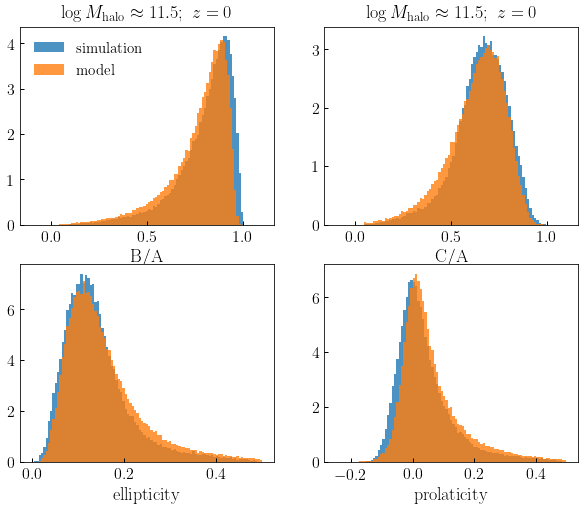

In [5]:
from ellipsoidal_halo_model import monte_carlo_halo_shapes

fig, _axes = plt.subplots(2, 2, figsize=(10, 8))
((ax0, ax1), (ax2, ax3)) = _axes
axes = ax0, ax1, ax2, ax3


axis_ratio_bins = np.linspace(-0.1, 1.1, 100)
ebins = np.linspace(0, 0.5, 100)
pbins = np.linspace(-0.25, 0.5, 100)

halo_sample, redshift = h0_z0, 0.

__=ax0.hist(halo_sample['halo_b_to_a'], bins=axis_ratio_bins, density=True, alpha=0.8, 
            color=mblue, label=r'${\rm simulation}$')
__=ax1.hist(halo_sample['halo_c_to_a'], bins=axis_ratio_bins, density=True, alpha=0.8, color=mblue)
__=ax2.hist(halo_sample['halo_ellipticity'], bins=ebins, density=True, alpha=0.8, color=mblue)
__=ax3.hist(halo_sample['halo_prolaticity'], bins=pbins, density=True, alpha=0.8, color=mblue)

model_b_to_a, model_c_to_a, model_e, model_p = monte_carlo_halo_shapes(
            np.log10(halo_sample['halo_mpeak']), redshift)
__=ax0.hist(model_b_to_a, bins=axis_ratio_bins, density=True, alpha=0.8, color=morange, label=r'${\rm model}$')
__=ax1.hist(model_c_to_a, bins=axis_ratio_bins, density=True, alpha=0.8, color=morange)
__=ax2.hist(model_e, bins=ebins, density=True, alpha=0.8, color=morange)
__=ax3.hist(model_p, bins=pbins, density=True, alpha=0.8, color=morange)


xlabel = ax0.set_xlabel(r'${\rm B/A}$')
xlabel = ax1.set_xlabel(r'${\rm C/A}$')
xlabel = ax2.set_xlabel(r'${\rm ellipticity}$')
xlabel = ax3.set_xlabel(r'${\rm prolaticity}$')
leg = ax0.legend()

title1 = ax0.set_title(r'$\log M_{\rm halo}\approx11.5;\ z=0$')
title1 = ax1.set_title(r'$\log M_{\rm halo}\approx11.5;\ z=0$')

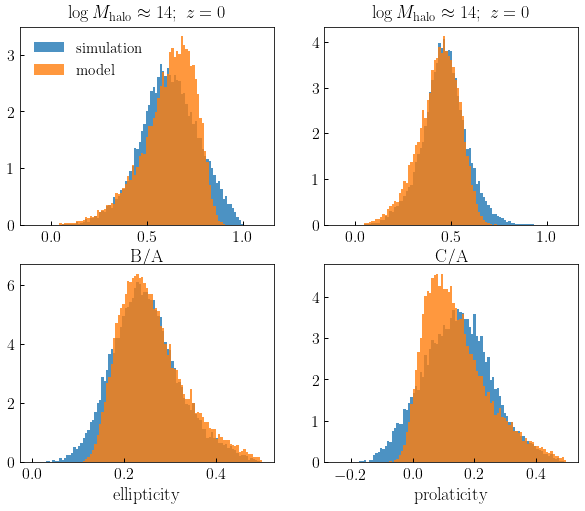

In [6]:
from ellipsoidal_halo_model import monte_carlo_halo_shapes

fig, _axes = plt.subplots(2, 2, figsize=(10, 8))
((ax0, ax1), (ax2, ax3)) = _axes
axes = ax0, ax1, ax2, ax3


axis_ratio_bins = np.linspace(-0.1, 1.1, 100)
ebins = np.linspace(0, 0.5, 100)
pbins = np.linspace(-0.25, 0.5, 100)

halo_sample, redshift = h3_z0, 0.

__=ax0.hist(halo_sample['halo_b_to_a'], bins=axis_ratio_bins, density=True, alpha=0.8, 
            color=mblue, label=r'${\rm simulation}$')
__=ax1.hist(halo_sample['halo_c_to_a'], bins=axis_ratio_bins, density=True, alpha=0.8, color=mblue)
__=ax2.hist(halo_sample['halo_ellipticity'], bins=ebins, density=True, alpha=0.8, color=mblue)
__=ax3.hist(halo_sample['halo_prolaticity'], bins=pbins, density=True, alpha=0.8, color=mblue)

model_b_to_a, model_c_to_a, model_e, model_p = monte_carlo_halo_shapes(
            np.log10(halo_sample['halo_mpeak']), redshift)
__=ax0.hist(model_b_to_a, bins=axis_ratio_bins, density=True, alpha=0.8, color=morange, label=r'${\rm model}$')
__=ax1.hist(model_c_to_a, bins=axis_ratio_bins, density=True, alpha=0.8, color=morange)
__=ax2.hist(model_e, bins=ebins, density=True, alpha=0.8, color=morange)
__=ax3.hist(model_p, bins=pbins, density=True, alpha=0.8, color=morange)


xlabel = ax0.set_xlabel(r'${\rm B/A}$')
xlabel = ax1.set_xlabel(r'${\rm C/A}$')
xlabel = ax2.set_xlabel(r'${\rm ellipticity}$')
xlabel = ax3.set_xlabel(r'${\rm prolaticity}$')
leg = ax0.legend()

title1 = ax0.set_title(r'$\log M_{\rm halo}\approx14;\ z=0$')
title1 = ax1.set_title(r'$\log M_{\rm halo}\approx14;\ z=0$')

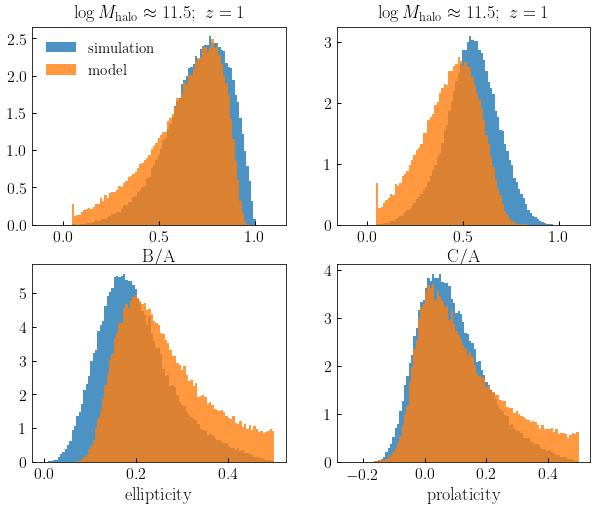

In [7]:
from ellipsoidal_halo_model import monte_carlo_halo_shapes

fig, _axes = plt.subplots(2, 2, figsize=(10, 8))
((ax0, ax1), (ax2, ax3)) = _axes
axes = ax0, ax1, ax2, ax3


axis_ratio_bins = np.linspace(-0.1, 1.1, 100)
ebins = np.linspace(0, 0.5, 100)
pbins = np.linspace(-0.25, 0.5, 100)

halo_sample, redshift = h0_z1, 1.

__=ax0.hist(halo_sample['halo_b_to_a'], bins=axis_ratio_bins, density=True, alpha=0.8, 
            color=mblue, label=r'${\rm simulation}$')
__=ax1.hist(halo_sample['halo_c_to_a'], bins=axis_ratio_bins, density=True, alpha=0.8, color=mblue)
__=ax2.hist(halo_sample['halo_ellipticity'], bins=ebins, density=True, alpha=0.8, color=mblue)
__=ax3.hist(halo_sample['halo_prolaticity'], bins=pbins, density=True, alpha=0.8, color=mblue)

model_b_to_a, model_c_to_a, model_e, model_p = monte_carlo_halo_shapes(
            np.log10(halo_sample['halo_mpeak']), redshift)
__=ax0.hist(model_b_to_a, bins=axis_ratio_bins, density=True, alpha=0.8, color=morange, label=r'${\rm model}$')
__=ax1.hist(model_c_to_a, bins=axis_ratio_bins, density=True, alpha=0.8, color=morange)
__=ax2.hist(model_e, bins=ebins, density=True, alpha=0.8, color=morange)
__=ax3.hist(model_p, bins=pbins, density=True, alpha=0.8, color=morange)


xlabel = ax0.set_xlabel(r'${\rm B/A}$')
xlabel = ax1.set_xlabel(r'${\rm C/A}$')
xlabel = ax2.set_xlabel(r'${\rm ellipticity}$')
xlabel = ax3.set_xlabel(r'${\rm prolaticity}$')
leg = ax0.legend()

title1 = ax0.set_title(r'$\log M_{\rm halo}\approx11.5;\ z=1$')
title1 = ax1.set_title(r'$\log M_{\rm halo}\approx11.5;\ z=1$')

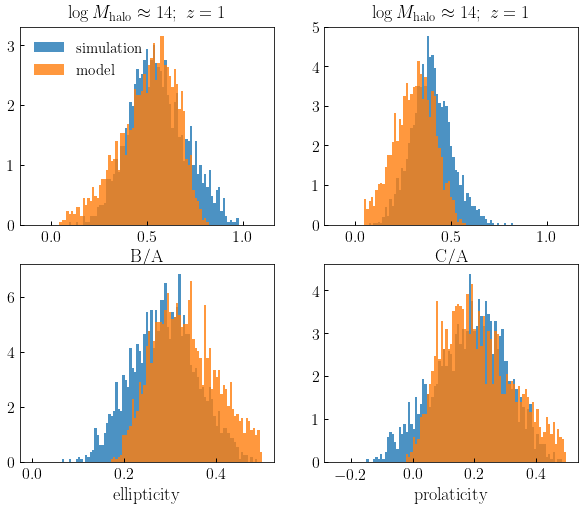

In [8]:
from ellipsoidal_halo_model import monte_carlo_halo_shapes

fig, _axes = plt.subplots(2, 2, figsize=(10, 8))
((ax0, ax1), (ax2, ax3)) = _axes
axes = ax0, ax1, ax2, ax3


axis_ratio_bins = np.linspace(-0.1, 1.1, 100)
ebins = np.linspace(0, 0.5, 100)
pbins = np.linspace(-0.25, 0.5, 100)

halo_sample, redshift = h3_z1, 1.

__=ax0.hist(halo_sample['halo_b_to_a'], bins=axis_ratio_bins, density=True, alpha=0.8, 
            color=mblue, label=r'${\rm simulation}$')
__=ax1.hist(halo_sample['halo_c_to_a'], bins=axis_ratio_bins, density=True, alpha=0.8, color=mblue)
__=ax2.hist(halo_sample['halo_ellipticity'], bins=ebins, density=True, alpha=0.8, color=mblue)
__=ax3.hist(halo_sample['halo_prolaticity'], bins=pbins, density=True, alpha=0.8, color=mblue)

model_b_to_a, model_c_to_a, model_e, model_p = monte_carlo_halo_shapes(
            np.log10(halo_sample['halo_mpeak']), redshift)
__=ax0.hist(model_b_to_a, bins=axis_ratio_bins, density=True, alpha=0.8, color=morange, label=r'${\rm model}$')
__=ax1.hist(model_c_to_a, bins=axis_ratio_bins, density=True, alpha=0.8, color=morange)
__=ax2.hist(model_e, bins=ebins, density=True, alpha=0.8, color=morange)
__=ax3.hist(model_p, bins=pbins, density=True, alpha=0.8, color=morange)


xlabel = ax0.set_xlabel(r'${\rm B/A}$')
xlabel = ax1.set_xlabel(r'${\rm C/A}$')
xlabel = ax2.set_xlabel(r'${\rm ellipticity}$')
xlabel = ax3.set_xlabel(r'${\rm prolaticity}$')
leg = ax0.legend()

title1 = ax0.set_title(r'$\log M_{\rm halo}\approx14;\ z=1$')
title1 = ax1.set_title(r'$\log M_{\rm halo}\approx14;\ z=1$')